In [2]:
##import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,GlobalMaxPooling1D,SpatialDropout1D



In [7]:
df_train = pd.read_csv("train.tsv",sep="\t")
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
df_train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [10]:
df_train.shape

(156060, 4)

In [11]:
df_test = pd.read_csv("test.tsv",sep="\t")
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [12]:
df_test.shape

(66292, 3)

In [13]:
df_test.columns

Index(['PhraseId', 'SentenceId', 'Phrase'], dtype='object')

In [15]:
df_train["Sentiment"].value_counts()## distribution of sentiment

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

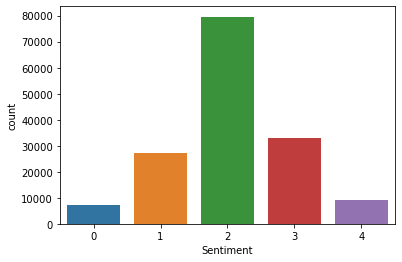

In [18]:
import seaborn as sns

sns.countplot(df_train["Sentiment"])


In [19]:
## cleaning the text
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

In [20]:
def clean_text(text):
    text = text.lower()
    
    for s in replace_list:
        text = text.replace(s,replace_list[s])
    text = ' '.join(text.split())
    return text

In [21]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


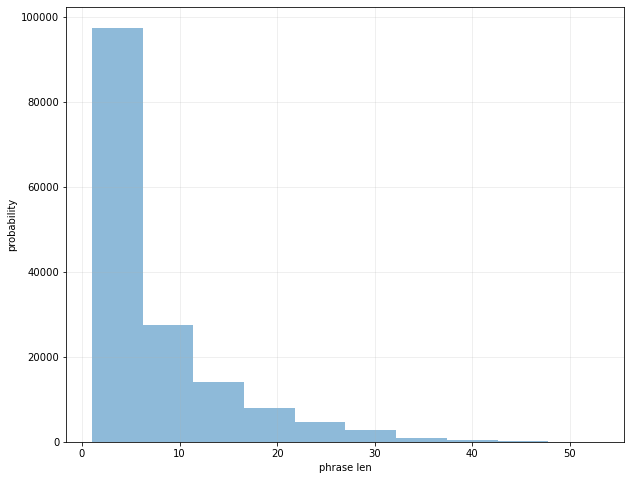

In [23]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.5)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [24]:
y_train = df_train['Sentiment']

In [25]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)

y_train = to_categorical(y_train)

In [26]:
batch_size = 512
epochs = 8

In [27]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim=256,input_length = max_phrase_len))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [28]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Epoch 1/8
275/275 [==============================] - 75s 274ms/step - loss: 1.0325 - accuracy: 0.5882 - val_loss: 0.9996 - val_accuracy: 0.5990
Epoch 2/8
275/275 [==============================] - 73s 266ms/step - loss: 0.8266 - accuracy: 0.6682 - val_loss: 1.0029 - val_accuracy: 0.6037
Epoch 3/8
275/275 [==============================] - 75s 273ms/step - loss: 0.7793 - accuracy: 0.6844 - val_loss: 1.0165 - val_accuracy: 0.6021
Epoch 4/8
275/275 [==============================] - 77s 278ms/step - loss: 0.7473 - accuracy: 0.6960 - val_loss: 1.0330 - val_accuracy: 0.5986
Epoch 5/8
275/275 [==============================] - 76s 276ms/step - loss: 0.7202 - accuracy: 0.7059 - val_loss: 1.0587 - val_accuracy: 0.5968
Epoch 6/8
275/275 [==============================] - 77s 280ms/step - loss: 0.6954 - accuracy: 0.7153 - val_loss: 1.0653 - val_accuracy: 0.6023
Epoch 7/8
275/275 [==============================] - 77s 281ms/step - loss: 0.6734 - accuracy: 0.7231 - val_loss: 1.1138 - val_accuracy:

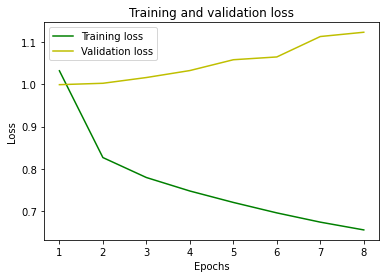

In [29]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

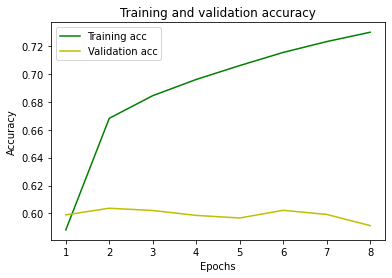

In [30]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
for key in history.history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [32]:
X_test = df_test['Phrase'].apply(lambda p: clean_text(p))
X_test.head(5)
tokenizer.fit_on_texts(X_test)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_phrase_len)

In [33]:
y_pred=model_lstm.predict_classes(X_test)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([2, 2, 2, ..., 1, 1, 2], dtype=int64)

In [34]:
batch_size = 512
epochs = 2

In [38]:
## model2s with recurrent dropout 0 and recurrent activation ="sigmoid"


model_lstm2 = Sequential()
model_lstm2.add(Embedding(input_dim = max_words, output_dim=256,input_length = max_phrase_len))
model_lstm2.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0,recurrent_activation="sigmoid"))
model_lstm2.add(Dense(5, activation = 'softmax'))
model_lstm2.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [39]:
history2 = model_lstm2.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Epoch 1/8
275/275 [==============================] - 20s 72ms/step - loss: 1.0334 - accuracy: 0.5871 - val_loss: 1.0092 - val_accuracy: 0.5941
Epoch 2/8
275/275 [==============================] - 19s 71ms/step - loss: 0.8297 - accuracy: 0.6659 - val_loss: 1.0068 - val_accuracy: 0.6002
Epoch 3/8
275/275 [==============================] - 21s 76ms/step - loss: 0.7818 - accuracy: 0.6846 - val_loss: 1.0119 - val_accuracy: 0.6020
Epoch 4/8
275/275 [==============================] - 20s 73ms/step - loss: 0.7484 - accuracy: 0.6963 - val_loss: 1.0241 - val_accuracy: 0.6012
Epoch 5/8
275/275 [==============================] - 20s 71ms/step - loss: 0.7208 - accuracy: 0.7055 - val_loss: 1.0559 - val_accuracy: 0.5953
Epoch 6/8
275/275 [==============================] - 20s 72ms/step - loss: 0.6955 - accuracy: 0.7154 - val_loss: 1.0681 - val_accuracy: 0.5952
Epoch 7/8
275/275 [==============================] - 20s 71ms/step - loss: 0.6740 - accuracy: 0.7229 - val_loss: 1.0889 - val_accuracy: 0.5945

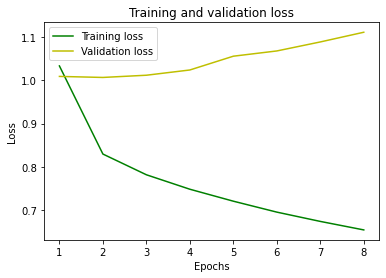

In [41]:
plt.clf()
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

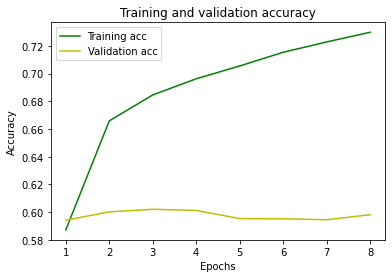

In [44]:
plt.clf()
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [45]:
X_test = df_test['Phrase'].apply(lambda p: clean_text(p))
X_test.head(5)
tokenizer.fit_on_texts(X_test)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_phrase_len)

In [46]:
y_pred2=model_lstm2.predict_classes(X_test)
y_pred2

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [48]:
df_pred = pd.DataFrame(y_pred2)

In [50]:
df_pred.value_counts()

2    42861
3    12122
1     9417
4     1490
0      402
dtype: int64

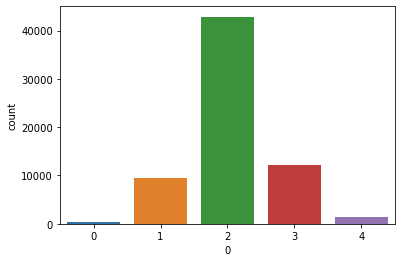

In [53]:
sns.countplot(df_pred[0])